In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Bidirectional, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU

In [2]:
# Load the dataset
df = pd.read_csv('..//dataset//final_dataset_compressed.csv')  # Replace with your dataset path

# Separating features and target
X = df[['Number of Lanes', 'Status of driver', 'Nature of environment', 'Velocity of vehicle', 'Distance between vehicles', 'Breaking capability']]
y = df['Collussion']

# Normalize the features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [3]:
print(X_train.shape, y_train.shape,X_scaled.shape)

(320000, 1, 6) (320000,) (400000, 1, 6)


# Model

In [4]:
def build_deep_rnn_bi_lstm():
    model = Sequential()
    
    # Add multiple SimpleRNN layers for Deep RNN
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(units=50, return_sequences=True))
    model.add(Dropout(0.1))

    # Add multiple Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=50)))
    model.add(Dropout(0.1))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [5]:
# Instantiate and train the model
model = build_deep_rnn_bi_lstm()
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/5
8000/8000 [==============================] - 75s 8ms/step - loss: 0.0390 - accuracy: 0.9815 - val_loss: 0.0334 - val_accuracy: 0.9834
Epoch 2/5
8000/8000 [==============================] - 58s 7ms/step - loss: 0.0322 - accuracy: 0.9833 - val_loss: 0.0346 - val_accuracy: 0.9837
Epoch 3/5
8000/8000 [==============================] - 57s 7ms/step - loss: 0.0313 - accuracy: 0.9835 - val_loss: 0.0316 - val_accuracy: 0.9831
Epoch 4/5
8000/8000 [==============================] - 62s 8ms/step - loss: 0.0306 - accuracy: 0.9837 - val_loss: 0.0287 - val_accuracy: 0.9845
Epoch 5/5
8000/8000 [==============================] - 69s 9ms/step - loss: 0.0302 - accuracy: 0.9839 - val_loss: 0.0310 - val_accuracy: 0.9837


In [6]:
import numpy as np

# Set numpy to display full float numbers
np.set_printoptions(suppress=True, precision=10)

In [7]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.2f}')

2500/2500 [==============================] - 10s 4ms/step - loss: 0.0312 - accuracy: 0.9835
Test Accuracy: 0.98


In [8]:

from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.16f}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.16f}')

2500/2500 [==============================] - 12s 3ms/step
Mean Squared Error (MSE): 0.0104589624432234
Root Mean Squared Error (RMSE): 0.1022690688489115


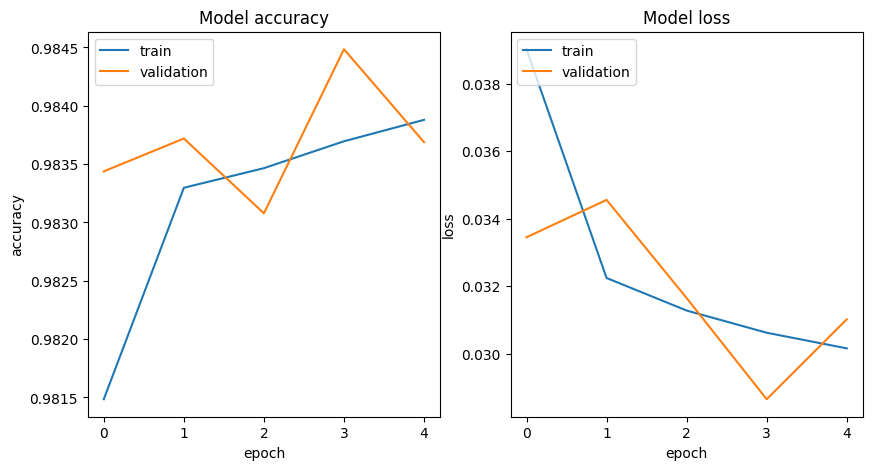

In [9]:
#visualizing the loss and accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()
